In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

import seaborn as sns

import cv2

import shutil
from pathlib import Path
import os

from sklearn.model_selection import train_test_split

from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, RandomRotation, RandomFlip, RandomZoom, RandomContrast, Rescaling
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input

from keras.utils import plot_model

from Libraries.get_absolute_path import get_absolute_path

# Partie 1 : Ouverture des images dans des datasets

In [2]:
train_folder = get_absolute_path(r"data\processed\train_test_split\train")
validation_folder = get_absolute_path(r"data\processed\train_test_split\validation")
test_folder = get_absolute_path(r"data\processed\train_test_split\test")


train_ds = image_dataset_from_directory(train_folder,
                                        label_mode="int",
                                        shuffle=True,
                                        batch_size=32,
                                        image_size=(224,224),
                                        seed=42)

val_ds = image_dataset_from_directory(validation_folder,
                                      label_mode="int",
                                      shuffle=True,
                                      batch_size=32,
                                      image_size=(224,224),
                                      seed=42)

test_ds = image_dataset_from_directory(test_folder,
                                       label_mode="int",
                                       shuffle=True,
                                       batch_size=32,
                                       image_size=(224,224),
                                       seed=42)
class_names = train_ds.class_names

Found 16932 files belonging to 4 classes.
Found 2116 files belonging to 4 classes.
Found 2117 files belonging to 4 classes.


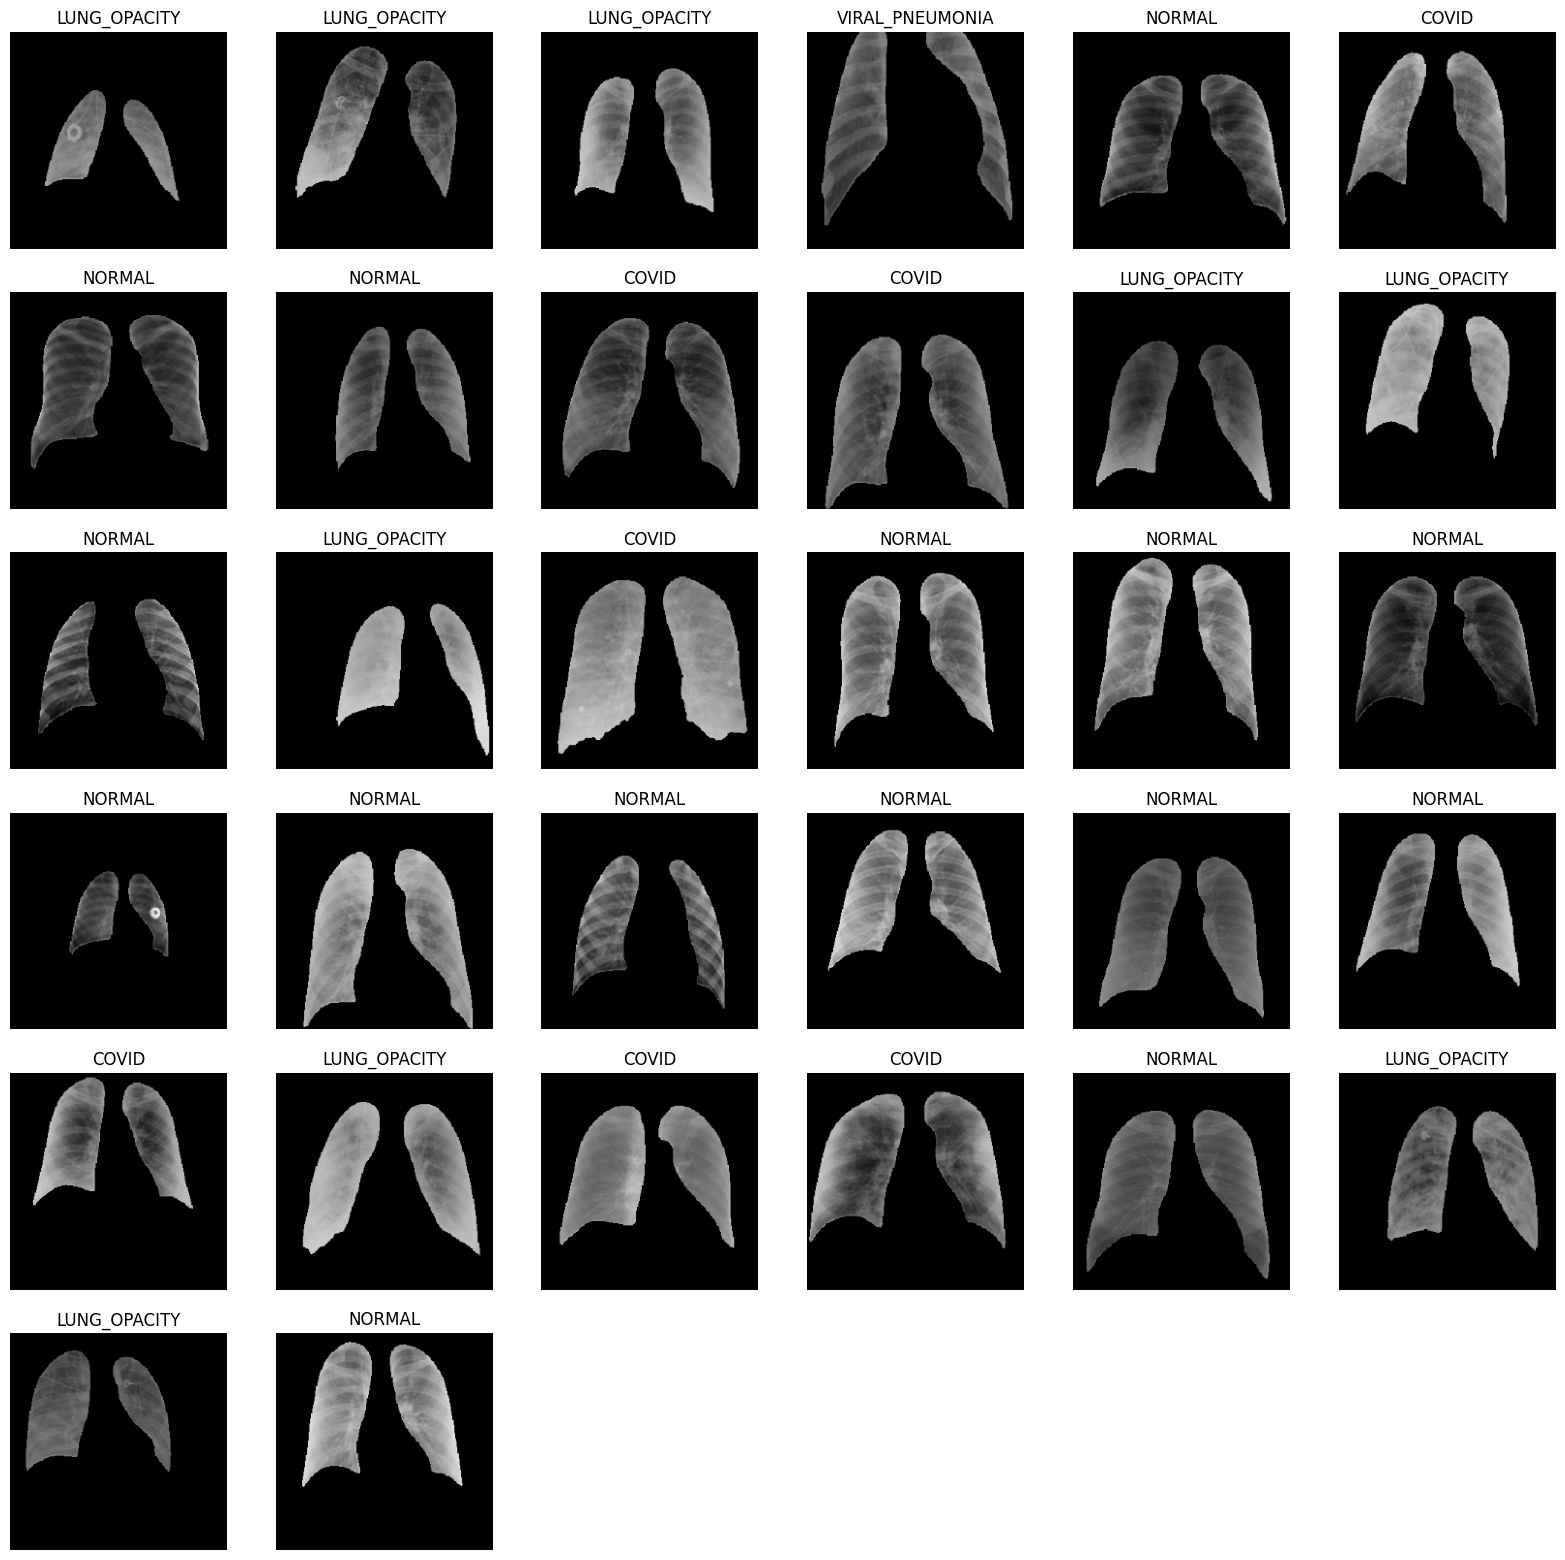

In [3]:
# Visualisation d'un échantillon des données

plt.figure(figsize=(20,40))

for images, labels in train_ds.take(1):  # Prendre un lot d'images et de labels
    for i, image in enumerate(images):
        plt.subplot(12,6,i+1)
        image = image / 255
        plt.imshow(image)
        label = labels[i].numpy()
        label_name = class_names[label]
        plt.title(label_name)
        plt.axis('off')

plt.show()

In [4]:
# Comme nous avons des classes déséquilibrées, nous allons utiliser des poids pondérés par leur présence dans le dataset. Pour ça on utilise la fonction
# compute_class_weight

labels = np.concatenate([y for _, y in test_ds], axis=0)

# Calcul des poids des classes
class_labels = np.unique(labels)
class_weight = compute_class_weight(class_weight='balanced', classes=class_labels, y=labels)
class_weight_dict = dict(enumerate(class_weight))

print("Poids des classes :", class_weight_dict)
#class_weight_dict = {0: 1.4631870031109575, 1: 0.8802245789145352, 2: 0.5191317144959529, 3: 3.934014869888476}

print(class_names)

Poids des classes : {0: 1.4620165745856353, 1: 0.8791528239202658, 2: 0.5193817468105987, 3: 3.949626865671642}
['COVID', 'LUNG_OPACITY', 'NORMAL', 'VIRAL_PNEUMONIA']


In [5]:
# Optimisation du chargement
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

# Partie 2 : Entraînement du modèle

In [ ]:
# Définition des callbacks

model_path = r"notebooks\AntoineB\artifacts\models\model_tl_vgg19_1.keras"

modelcheckpoint = ModelCheckpoint(filepath=model_path,
                                  monitor='val_accuracy',
                                  verbose=1,
                                  save_best_only=True,
                                  mode="max")

earlystop = EarlyStopping(monitor="val_loss",
                          mode="min",
                          min_delta=0,
                          patience=6,
                          verbose=1,
                          restore_best_weights=True)

reducelr = ReduceLROnPlateau(monitor="val_loss",
                             min_delta=0.001,
                             patience=3,
                             factor=0.5,
                             cooldown=2,
                             verbose=1)

In [ ]:
with tf.device('/GPU:0'):

  # Modèle VGG19
  base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224,224,3), pooling="max")

  # Freeze des couches du Xception
  base_model.trainable = False

  # Couche d'entrée
  inputs = Input(shape=(224, 224, 3))

  # Data augmentation
  x = RandomFlip("horizontal")(inputs)
  x = RandomRotation(0.1, fill_mode='constant', fill_value=0)(x)
  x = RandomZoom(0.2, fill_mode='constant', fill_value=0)(x)
  x = RandomContrast(0.2)(x)

  # preprocessing
  x = preprocess_input(x)

  # Construction du modèle
  x = base_model(x)
  x = Dense(128, activation="relu")(x)
  x = Dropout(rate=0.5)(x)
  outputs = Dense(4, activation="softmax")(x)

  model = Model(inputs=inputs, outputs=outputs)
  optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001)
  model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

  model.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ random_flip (RandomFlip)  │ (None, 224, 224, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ random_rotation           │ (None, 224, 224, 3)    │              0 │ random_flip[0][0]      │
│ (RandomRotation)          │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ random_zoom (RandomZoom)  │ (None, 224, 224, 3)    │              0 │ random_rotation[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ random_contrast           │ (None, 224, 224, 3)    │              0 │ random_zoom[0][0]      │
│ (RandomContrast)          │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 224, 224)       │              0 │ random_contrast[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 224, 224)       │              0 │ random_contrast[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_2 (GetItem)      │ (None, 224, 224)       │              0 │ random_contrast[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack (Stack)             │ (None, 224, 224, 3)    │              0 │ get_item[0][0],        │
│                           │                        │                │ get_item_1[0][0],      │
│                           │                        │                │ get_item_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 224, 224, 3)    │              0 │ stack[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg19 (Functional)        │ (None, 512)            │     20,024,384 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │         65,664 │ vgg19[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 4)              │            516 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 20,090,564 (76.64 MB)

 Trainable params: 66,180 (258.52 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

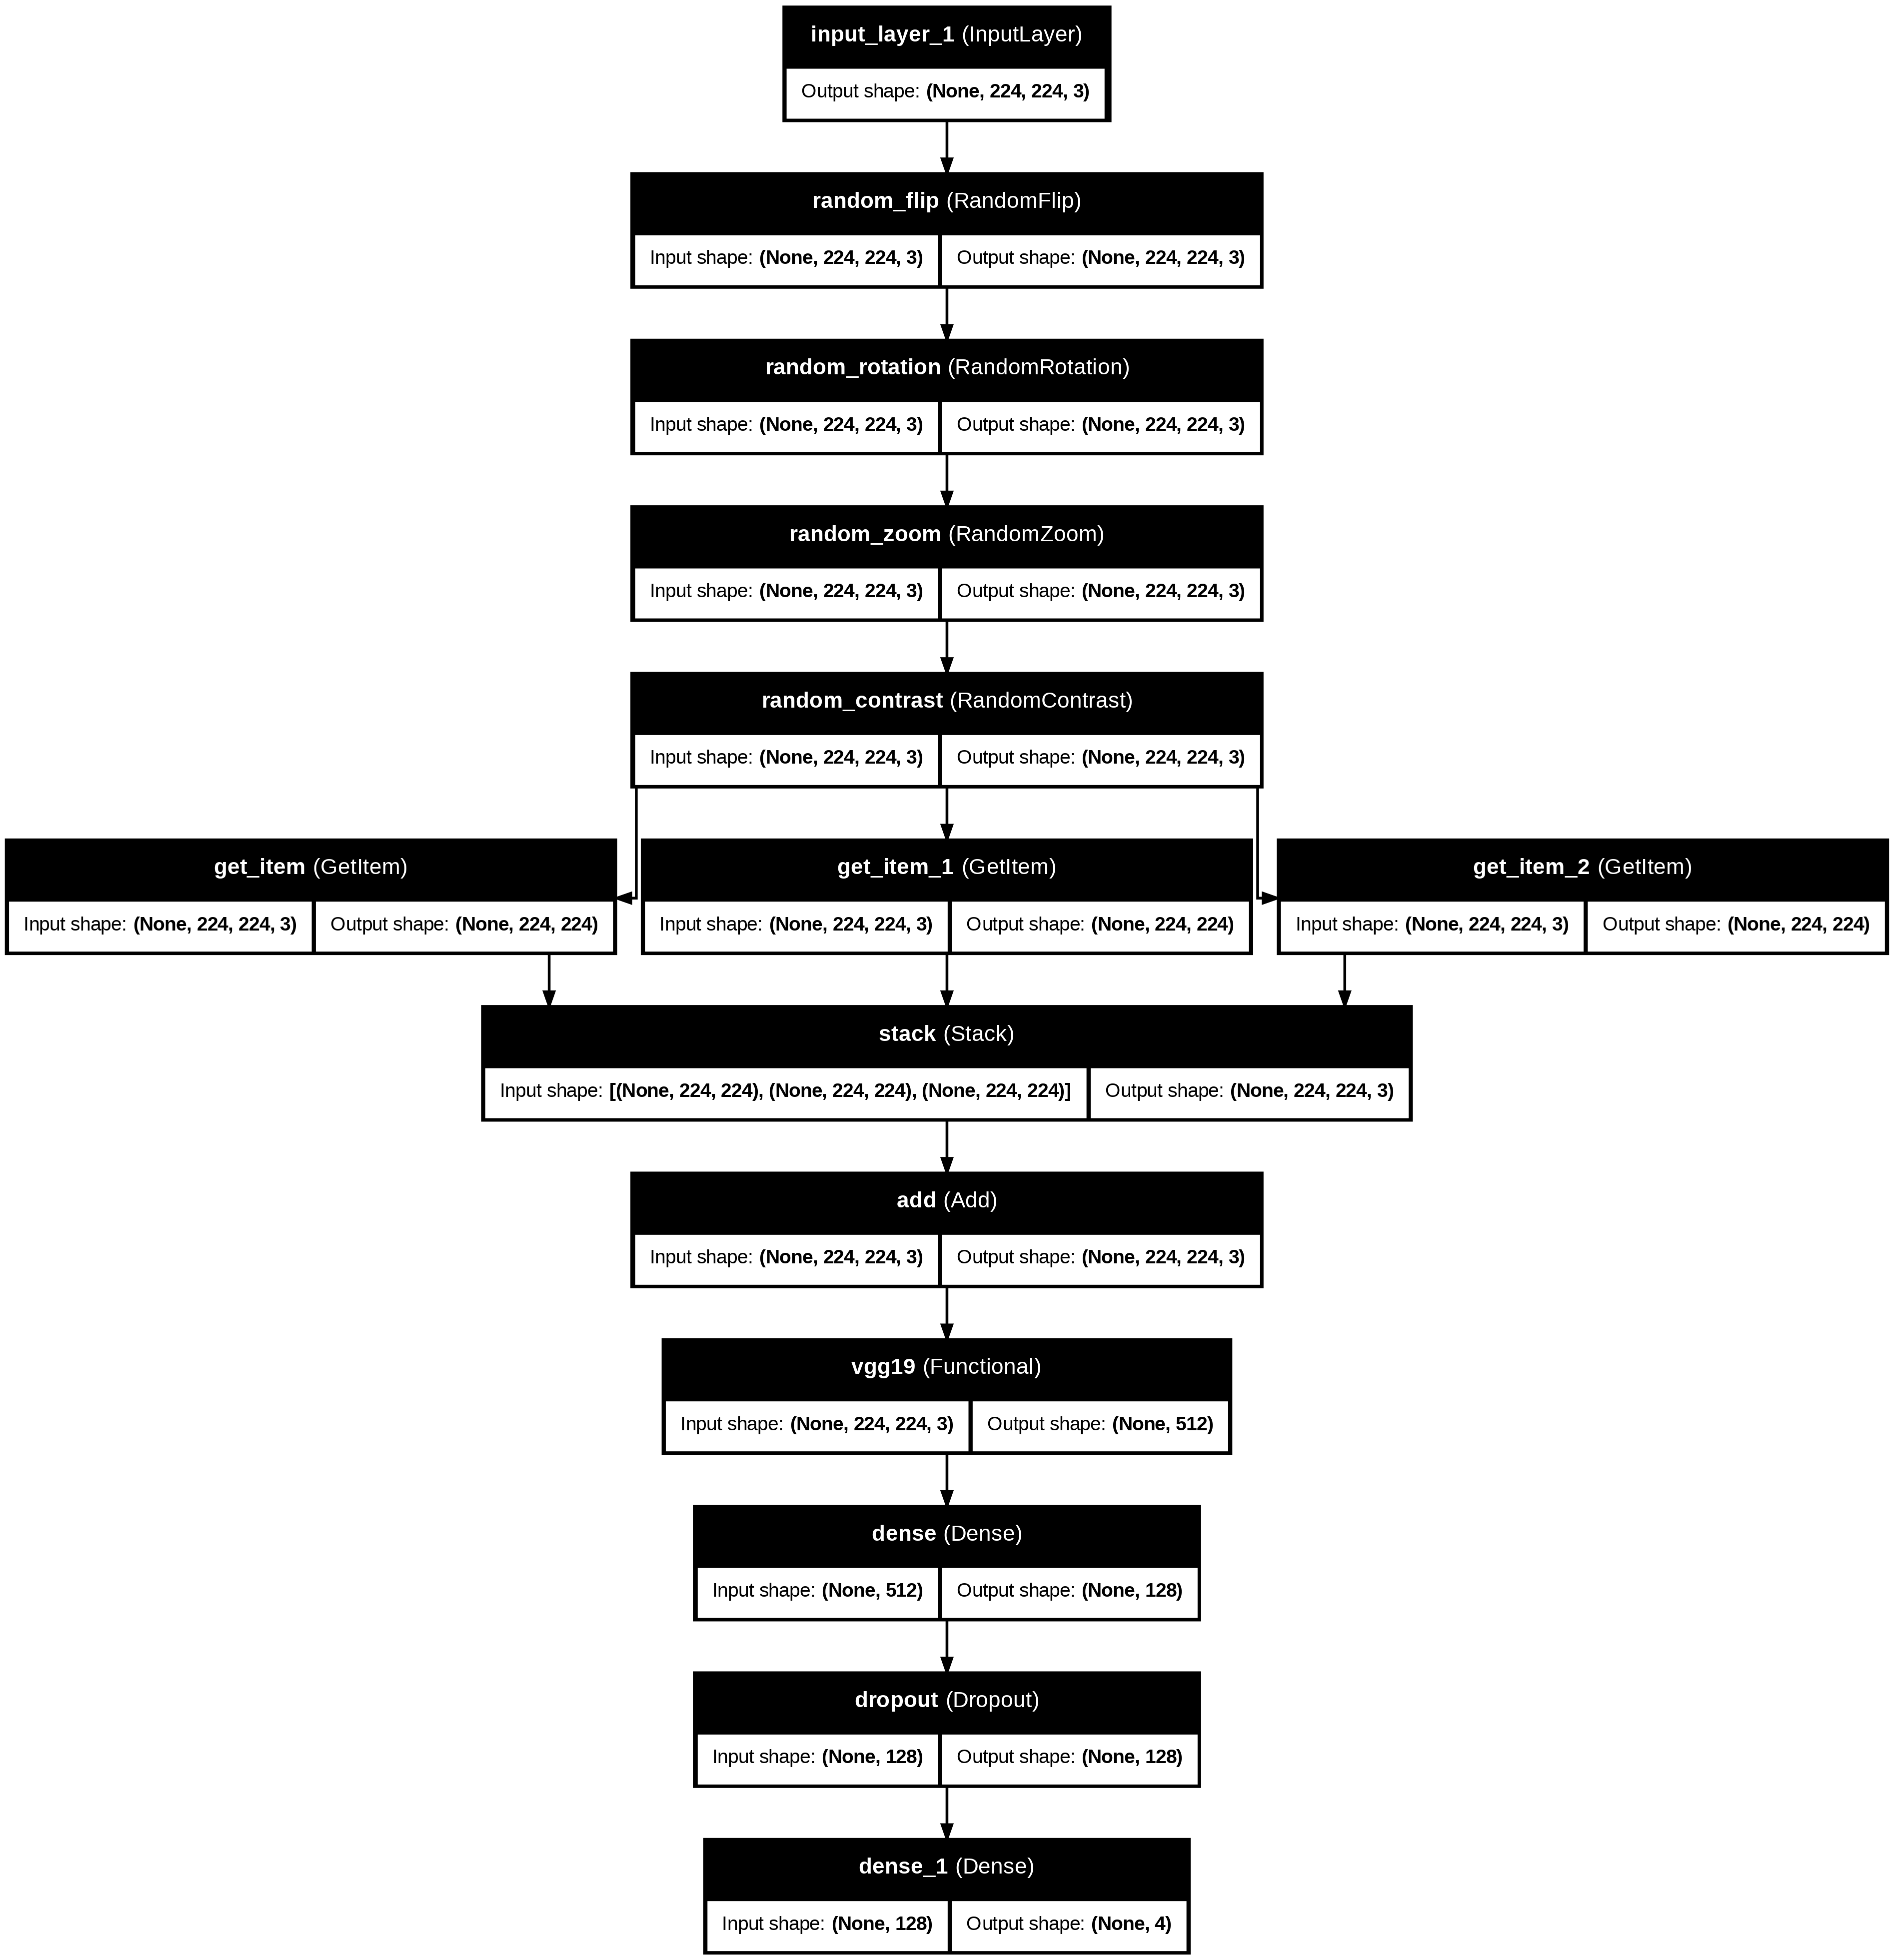

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
with tf.device('/GPU:0'):
  history_model_1 = model.fit(train_ds,
                              validation_data=val_ds,
                              batch_size=32,
                              epochs=100,
                              class_weight=class_weight_dict,
                              callbacks=[earlystop, reducelr, modelcheckpoint])

Epoch 1/100
530/530 ━━━━━━━━━━━━━━━━━━━━ 0s 924ms/step - accuracy: 0.4004 - loss: 6.2953
Epoch 1: val_accuracy improved from -inf to 0.56853, saving model to /content/drive/MyDrive/Colab Notebooks/Projet COVID-19/model_tl_vgg19_1.keras
530/530 ━━━━━━━━━━━━━━━━━━━━ 571s 1s/step - accuracy: 0.4005 - loss: 6.2887 - val_accuracy: 0.5685 - val_loss: 1.0558 - learning_rate: 0.0010
Epoch 2/100
528/530 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5193 - loss: 1.0872
Epoch 2: val_accuracy improved from 0.56853 to 0.61106, saving model to /content/drive/MyDrive/Colab Notebooks/Projet COVID-19/model_tl_vgg19_1.keras
530/530 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - accuracy: 0.5194 - loss: 1.0869 - val_accuracy: 0.6111 - val_loss: 0.9695 - learning_rate: 0.0010
Epoch 3/100
530/530 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5697 - loss: 0.9597
Epoch 3: val_accuracy improved from 0.61106 to 0.64414, saving model to /content/drive/MyDrive/Colab Notebooks/Projet COVID-19/model_tl_vgg19_1.keras
530

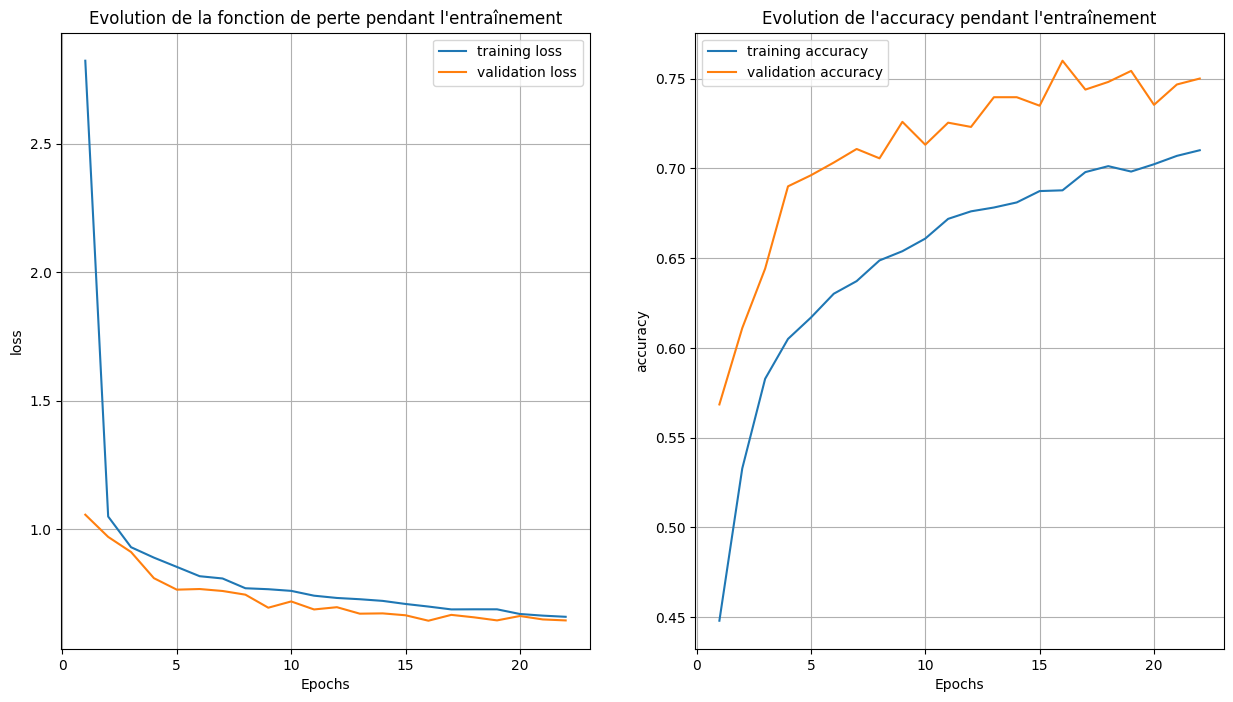

In [ ]:
# Visualisation de l'historique de'entraînement
train_loss = history_model_1.history['loss']
validation_loss = history_model_1.history['val_loss']

train_acc = history_model_1.history['accuracy']
validation_acc = history_model_1.history['val_accuracy']

plt.figure(figsize=(15,8))
plt.subplot(121)
plt.plot(np.arange(1,23,1), train_loss, label='training loss')
plt.plot(np.arange(1,23,1), validation_loss, label='validation loss')
plt.title("Evolution de la fonction de perte pendant l'entraînement")
plt.xlabel('Epochs')
plt.ylabel("loss")
plt.legend()
plt.grid('off')

plt.subplot(122)
plt.plot(np.arange(1,23,1), train_acc, label='training accuracy')
plt.plot(np.arange(1,23,1), validation_acc, label='validation accuracy')
plt.title("Evolution de l'accuracy pendant l'entraînement")
plt.xlabel('Epochs')
plt.ylabel("accuracy")
plt.legend()
plt.grid('off')

plt.show()

67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step


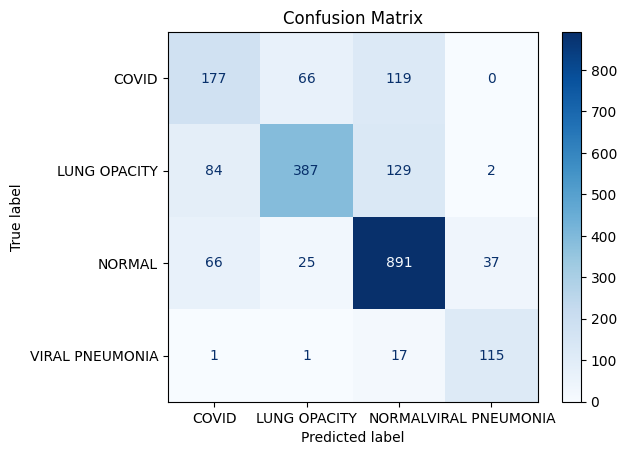

              precision    recall  f1-score   support

           0       0.54      0.49      0.51       362
           1       0.81      0.64      0.72       602
           2       0.77      0.87      0.82      1019
           3       0.75      0.86      0.80       134

    accuracy                           0.74      2117
   macro avg       0.72      0.72      0.71      2117
weighted avg       0.74      0.74      0.74      2117



In [ ]:
# Création de la matrice de confusion sur les données de test
true_labels = np.concatenate([y for _, y in test_ds], axis=0)
predictions = model.predict(test_ds)  # Prédictions du modèle
predicted_classes = np.argmax(predictions, axis=1)  # Classes prédites

# Créez la matrice de confusion
cm = confusion_matrix(true_labels, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Affichez la matrice
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Affichage du rapport de classification
print(classification_report(true_labels, predicted_classes))

In [ ]:
with tf.device('/GPU:0'):

  for layer in base_model.layers[:]:
      layer.trainable = True

  optimizer = tf.keras.optimizers.Adamax(learning_rate=1e-4)
  model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
with tf.device('/GPU:0'):
  history_model_2 = model.fit(train_ds,
                              validation_data=val_ds,
                              batch_size=32,
                              epochs=100,
                              initial_epoch=22,
                              class_weight=class_weight_dict,
                              callbacks=[earlystop, reducelr, modelcheckpoint])

Epoch 23/100
530/530 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.4432 - loss: 1.1692
Epoch 23: val_accuracy did not improve from 0.75992
530/530 ━━━━━━━━━━━━━━━━━━━━ 45s 77ms/step - accuracy: 0.4434 - loss: 1.1687 - val_accuracy: 0.6474 - val_loss: 0.7548 - learning_rate: 1.0000e-04
Epoch 24/100
529/530 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.6868 - loss: 0.6773
Epoch 24: val_accuracy did not improve from 0.75992
530/530 ━━━━━━━━━━━━━━━━━━━━ 40s 75ms/step - accuracy: 0.6868 - loss: 0.6773 - val_accuracy: 0.7273 - val_loss: 0.6203 - learning_rate: 1.0000e-04
Epoch 25/100
529/530 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7336 - loss: 0.6017
Epoch 25: val_accuracy did not improve from 0.75992
530/530 ━━━━━━━━━━━━━━━━━━━━ 40s 75ms/step - accuracy: 0.7336 - loss: 0.6016 - val_accuracy: 0.7547 - val_loss: 0.5700 - learning_rate: 1.0000e-04
Epoch 26/100
529/530 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7660 - loss: 0.5516
Epoch 26: val_accuracy did not improve from 0.7

In [ ]:
combined_history = {key: history_model_1.history[key][:16] + history_model_2.history[key] for key in history_model_1.history.keys()}

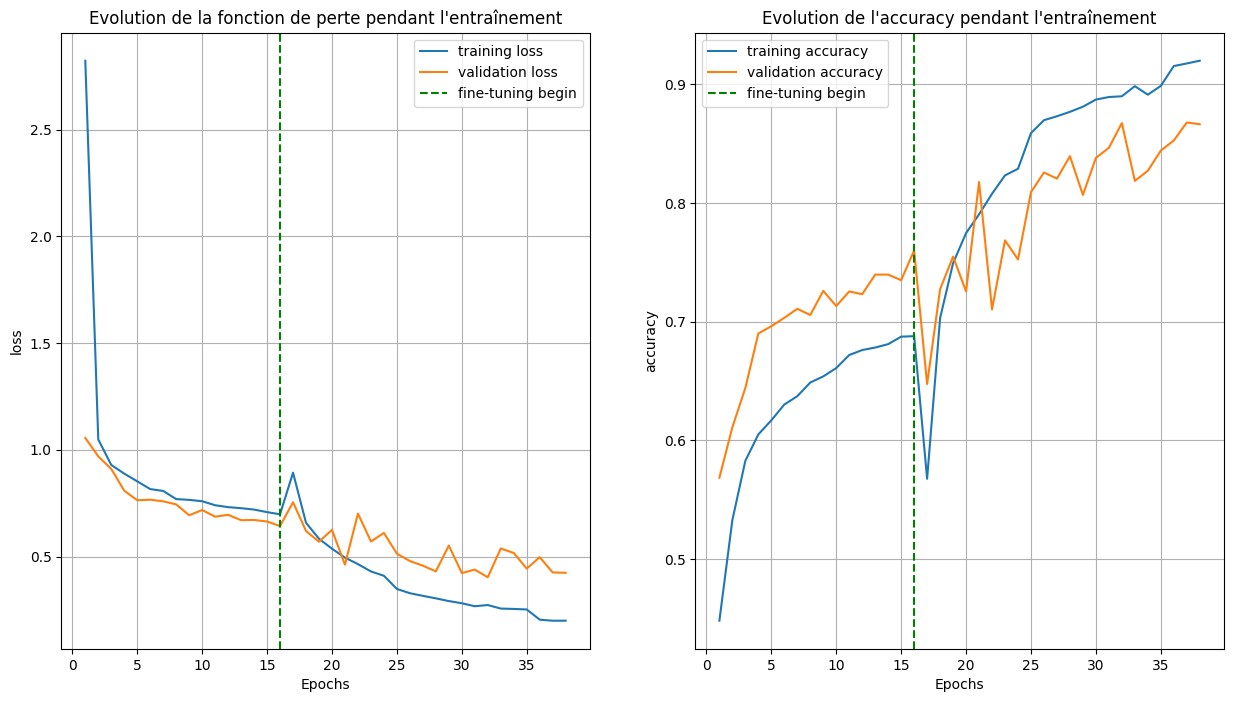

In [ ]:
# Visualisation de l'historique de'entraînement
train_loss = combined_history['loss']
validation_loss = combined_history['val_loss']

train_acc = combined_history['accuracy']
validation_acc = combined_history['val_accuracy']

plt.figure(figsize=(15,8))
plt.subplot(121)
plt.plot(np.arange(1,39,1), train_loss, label='training loss')
plt.plot(np.arange(1,39,1), validation_loss, label='validation loss')
plt.axvline(x=16, color='g', linestyle='--', label='fine-tuning begin')
plt.title("Evolution de la fonction de perte pendant l'entraînement")
plt.xlabel('Epochs')
plt.ylabel("loss")
plt.legend()
plt.grid('off')

plt.subplot(122)
plt.plot(np.arange(1,39,1), train_acc, label='training accuracy')
plt.plot(np.arange(1,39,1), validation_acc, label='validation accuracy')
plt.axvline(x=16, color='g', linestyle='--', label='fine-tuning begin')
plt.title("Evolution de l'accuracy pendant l'entraînement")
plt.xlabel('Epochs')
plt.ylabel("accuracy")
plt.legend()
plt.grid('off')

plt.show()

67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step


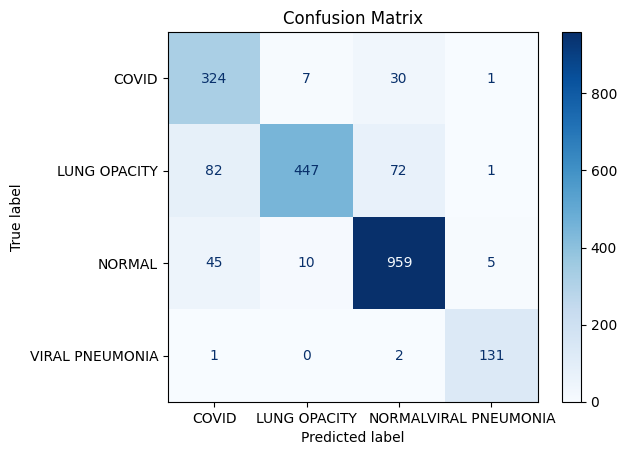

              precision    recall  f1-score   support

           0       0.72      0.90      0.80       362
           1       0.96      0.74      0.84       602
           2       0.90      0.94      0.92      1019
           3       0.95      0.98      0.96       134

    accuracy                           0.88      2117
   macro avg       0.88      0.89      0.88      2117
weighted avg       0.89      0.88      0.88      2117



In [ ]:
# Création de la matrice de confusion sur les données de test
true_labels = np.concatenate([y for _, y in test_ds], axis=0)
predictions = model.predict(test_ds)  # Prédictions du modèle
predicted_classes = np.argmax(predictions, axis=1)  # Classes prédites

# Créez la matrice de confusion
cm = confusion_matrix(true_labels, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Affichez la matrice
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Affichage du rapport de classification
print(classification_report(true_labels, predicted_classes))

In [ ]:
# Sauvegarde du modèle

model.save(r"notebooks\AntoineB\artifacts\models\model_tl_vgg19_final.keras")
model.save_weights(r"notebooks\AntoineB\artifacts\models\model_tl_vgg19_final.weights.h5")

# Partie 3 : Interprétabilité

In [6]:
# Réimportation du dernier modèle

from tensorflow.keras.models import load_model

model = load_model(get_absolute_path(r"notebooks\AntoineB\artifacts\models\model_tl_vgg19_final.keras"))
base_model = model.get_layer("vgg19")
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_flip         │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (RandomFlip)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_rotation     │ (None, 224, 224,  │          0 │ random_flip[0][0] │
│ (RandomRotation)    │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_zoom         │ (None, 224, 224,  │          0 │ random_rotation[… │
│ (RandomZoom)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_contrast     │ (None, 224, 224,  │          0 │ random_zoom[0][0] │
│ (RandomContrast)    │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ random_contrast[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ random_contrast[… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ random_contrast[… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg19 (Functional)  │ (None, 512)       │ 20,024,384 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     65,664 │ vgg19[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 4)         │        516 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 60,271,694 (229.92 MB)

 Trainable params: 20,090,564 (76.64 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 40,181,130 (153.28 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


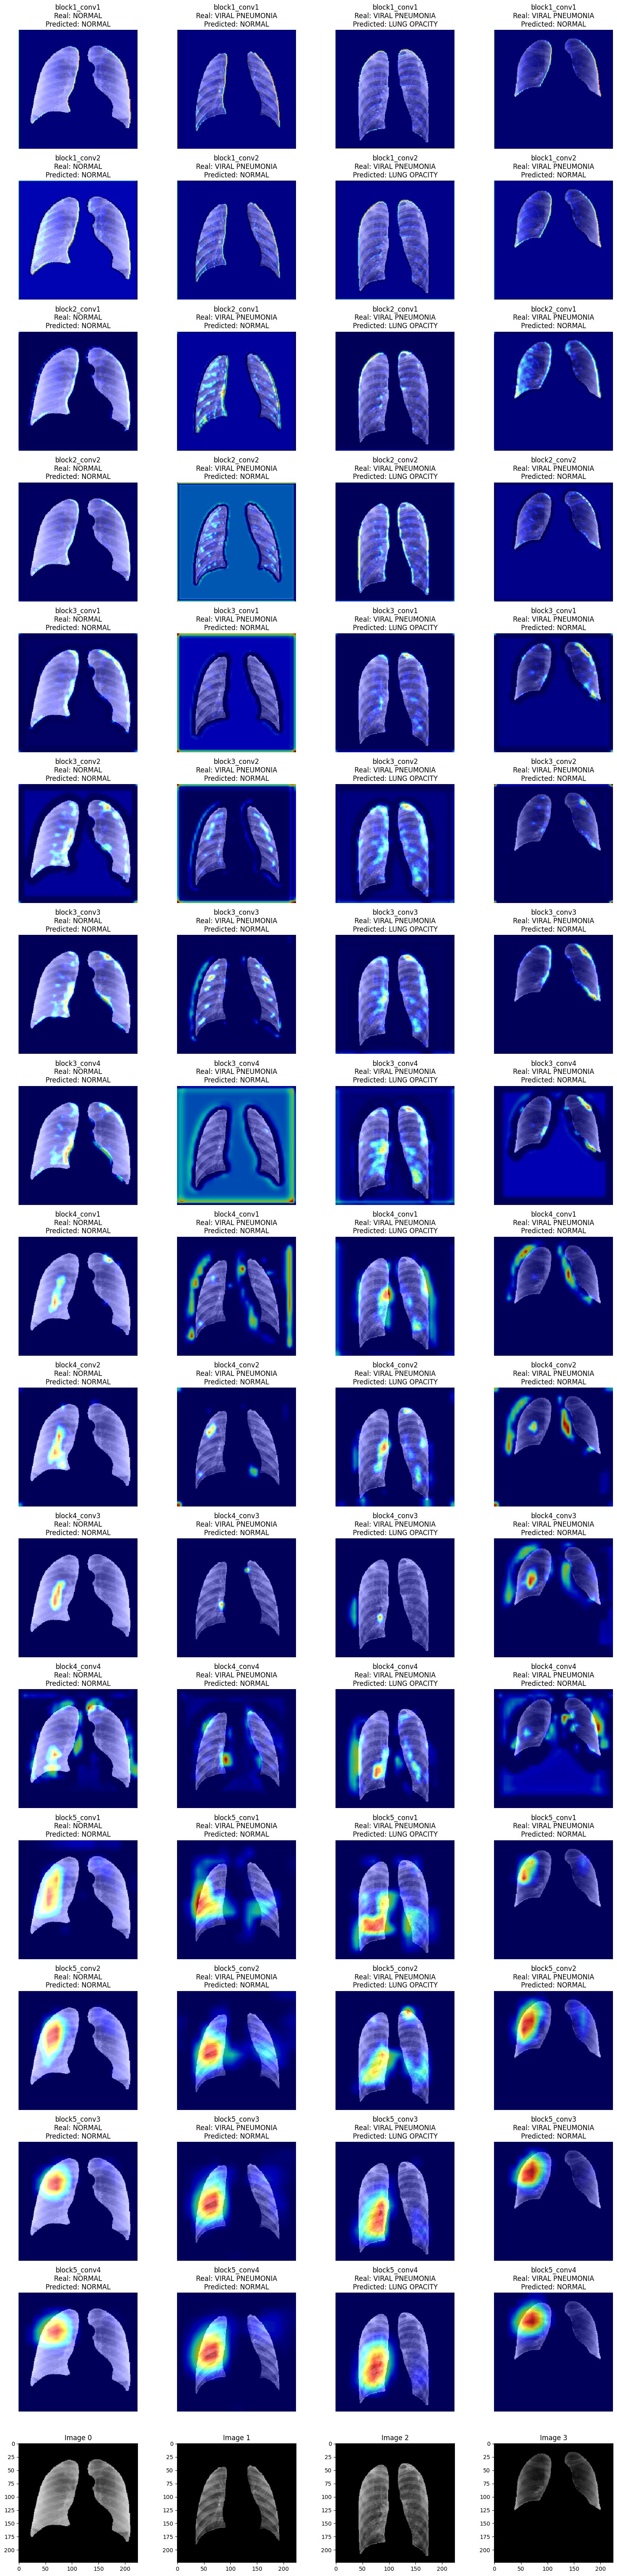

In [7]:
def grad_cam(img, model, base_model, layer_name : str, is_base_model_layer: bool):
    # Sélection de la couche dans le bon modèle
    if is_base_model_layer:
        layer = base_model.get_layer(layer_name)
        grad_model = Model(inputs=base_model.input, outputs=[layer.output, base_model.output])
        img_preprocessed = preprocess_input(img)  # Prétraitement requis pour VGG19
        img_preprocessed = tf.expand_dims(img_preprocessed, axis=0)  # Ajout de la dimension batch
    else:
        layer = model.get_layer(layer_name)
        grad_model = Model(inputs=model.input, outputs=[layer.output, model.output])
        img_preprocessed = preprocess_input(img)  # Prétraitement requis pour VGG19
        img_preprocessed = tf.expand_dims(img_preprocessed, axis=0)  # Ajout de la dimension batch


    # Calcul des gradients
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_preprocessed)
        predicted_class = tf.argmax(predictions[0])
        loss = predictions[:, predicted_class]

    # Calcul des gradients par rapport aux activations de la couche convolutionnelle
    grads = tape.gradient(loss, conv_outputs)

    # Moyenne pondérée des gradients pour chaque canal
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Pondération des activations par les gradients calculés
    conv_outputs = conv_outputs[0] # Supprimer la dimension batch
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    # Normalisation de la heatmap
    heatmap = tf.maximum(heatmap, 0) # Se concentrer uniquement sur les valeurs positives
    heatmap /= tf.math.reduce_max(heatmap) # Normalisation entre 0 et 1
    heatmap = heatmap.numpy() # Convertir en tableau numpy pour la visualisation

    # Redimensionner la heatmap pour correspondre à la taille de l'image d'origine
    heatmap_resized = tf.image.resize(heatmap[..., np.newaxis], (img_preprocessed.shape[1], img_preprocessed.shape[2])).numpy()
    heatmap_resized = np.squeeze(heatmap_resized, axis=-1) # Supprimer la dimension de taille 1 à la fin du tableau

    # Colorier la heatmap avec une palette (par exemple "jet")
    heatmap_colored = plt.cm.jet(heatmap_resized)[..., :3] # Récupérer les canaux R, G, B
    # Inversion des canaux BGR -> RGB
    img_rgb = img[..., ::-1]

    # Superposer la heatmap à l'image
    superposed_img = heatmap_colored * 0.7 + img / 255.0
    image_grad_cam = np.clip(superposed_img, 0, 1) # Garantit que toutes les valeurs de l'image finale se situent entre
    # 0 et 1

    return image_grad_cam, predicted_class

def show_grad_cam_cnn(images, labels, predicted_labels, model, base_model, class_names):
    number_of_images = images.shape[0]

    # Récupérer les couches convolutives du modèle principal
    conv_layers_model = [(layer.name, False) for layer in model.layers if isinstance(layer, Conv2D)]

    # Ajouter les couches convolutives du modèle pré-entraîné
    conv_layers_base_model = [(layer.name, True) for layer in base_model.layers if isinstance(layer, Conv2D)]

    # Fusion des deux listes
    conv_layers = conv_layers_model + conv_layers_base_model

    plt.figure(figsize=(16,64))

    for j, (layer_name, is_base_model_layer) in enumerate(conv_layers):

        for i in range(number_of_images):

            subplot_index = i + 1 + j * number_of_images
            plt.subplot(len(conv_layers)+1, number_of_images, subplot_index)

            # Obtenir l'image avec la carte de chaleur superposée
            grad_cam_image, predicted_class = grad_cam(images[i], model, base_model, layer_name, is_base_model_layer)

            # Afficher l'image avec Grad-CAM
            plt.title(f'{layer_name}\nReal: {class_names[labels[i]]}\nPredicted: {class_names[predicted_labels[i]]}')
            plt.imshow(grad_cam_image)
            plt.axis("off")
    for i in range(number_of_images):
      subplot_index = i + 1 + (len(conv_layers)) * number_of_images
      plt.subplot(len(conv_layers)+1, number_of_images, subplot_index)
      plt.title("Image " + str(i))
      plt.imshow(images[i])
    plt.tight_layout()
    plt.show()


X = np.array([img.numpy() for img, _ in test_ds.take(2)][0]).astype(np.uint8)
y = np.array([label.numpy() for _, label in test_ds.take(2)][0])

# Sélection des images spécifiques
images = X[[4, 8, 15, 19]]
labels = y[[4, 8, 15, 19]]
predicted_labels = np.argmax(model.predict(images), axis=1)

show_grad_cam_cnn(images, labels, predicted_labels, model, base_model, class_names)

In [9]:
test_ds = test_ds.map(lambda img, label: (preprocess_input(img), label))

67/67 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step


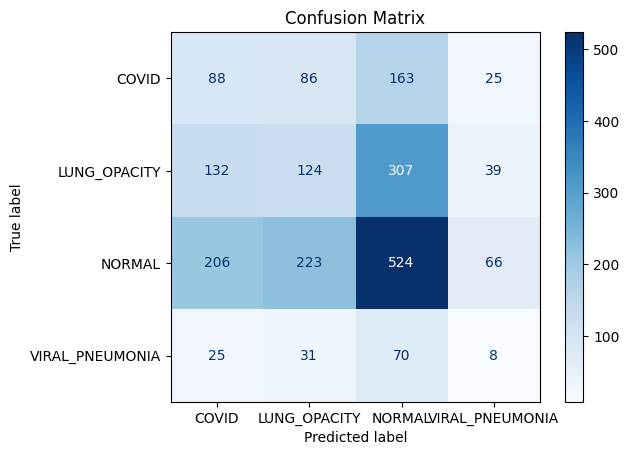

              precision    recall  f1-score   support

           0       0.20      0.24      0.22       362
           1       0.27      0.21      0.23       602
           2       0.49      0.51      0.50      1019
           3       0.06      0.06      0.06       134

    accuracy                           0.35      2117
   macro avg       0.25      0.26      0.25      2117
weighted avg       0.35      0.35      0.35      2117



In [7]:
# Création de la matrice de confusion sur les données de test
true_labels = np.concatenate([y for _, y in test_ds], axis=0)
predictions = model.predict(test_ds)  # Prédictions du modèle
predicted_classes = np.argmax(predictions, axis=1)  # Classes prédites

# Créez la matrice de confusion
cm = confusion_matrix(true_labels, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Affichez la matrice
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Affichage du rapport de classification
classification_report = classification_report(true_labels, predicted_classes)
print(classification_report)

np.save(get_absolute_path(r"reports/figures/Classification_report_TL_vgg19"), classification_report)